# KerasSpiking Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras_spiking

tf.random.set_seed(0)
np.random.seed(0)

[255 253 235]


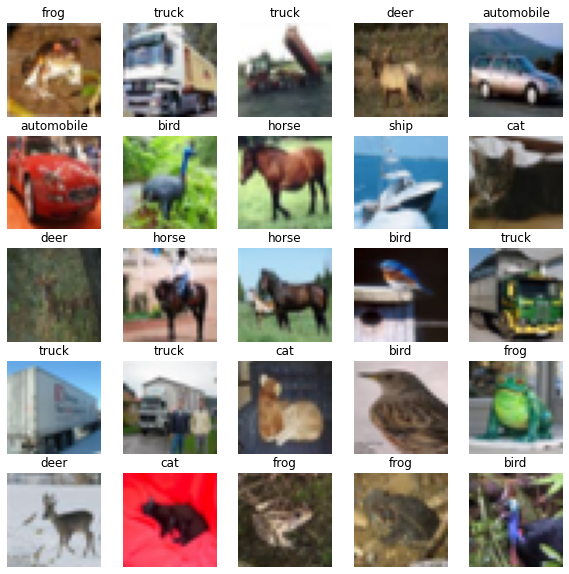

In [2]:
((train_images, train_labels),(test_images, test_labels),) = tf.keras.datasets.cifar10.load_data()
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

# maximum of each colour is 255
print(np.max(train_images[0], axis=(0,1)))

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

## Non-spiking model

In [3]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(32, 32,3)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)


def train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)

    print("\nTest accuracy:", test_acc)


train(model, train_images, test_images)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.0217 - accuracy: 0.2724
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8070 - accuracy: 0.3539
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7416 - accuracy: 0.3782
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7116 - accuracy: 0.3905
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6810 - accuracy: 0.4005
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6805 - accuracy: 0.4000
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6633 - accuracy: 0.4056
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6590 - accuracy: 0.4065
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6463 - accuracy: 0.4104
Epoch 10/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.646

## Conversion to Spiking Model

In [4]:
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

In [ ]:
spiking_model = tf.keras.Sequential(
    [
        # add temporal dimension to the input shape; we can set it to None,
        # to allow the model to flexibly run for different lengths of time
        tf.keras.layers.Reshape((-1, 32 * 32 * 3), input_shape=(None, 32, 32, 3)),
        # we can use Keras' TimeDistributed wrapper to allow the Dense layer
        # to operate on temporal data
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # replace the "relu" activation in the non-spiking model with a
        # spiking equivalent
        keras_spiking.SpikingActivation("relu", spiking_aware_training=False),
        # use average pooling layer to average spiking output over time
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spiking_model, train_sequences, test_sequences)

In [ ]:
def check_output(seq_model, modify_dt=None):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)

    has_global_average_pooling = False
    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_sequences)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * spike_layer.dt,
            tf.nn.softmax(output[ii]),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Test accuracy: 19.42%
Spike rate per neuron (Hz): min=0.00 mean=0.52 max=100.00


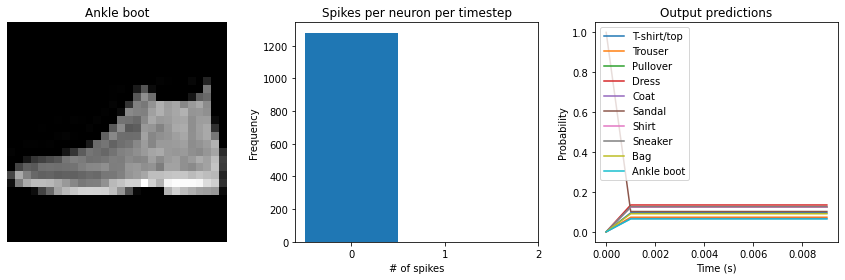

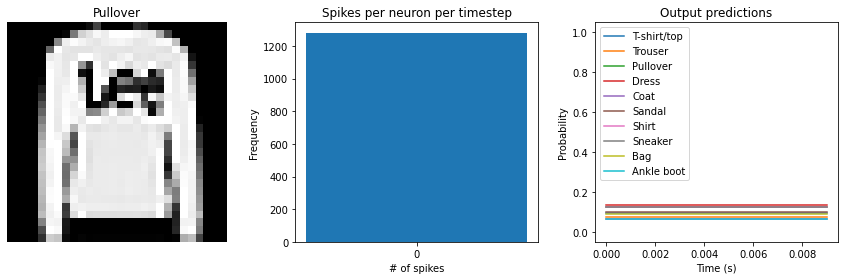

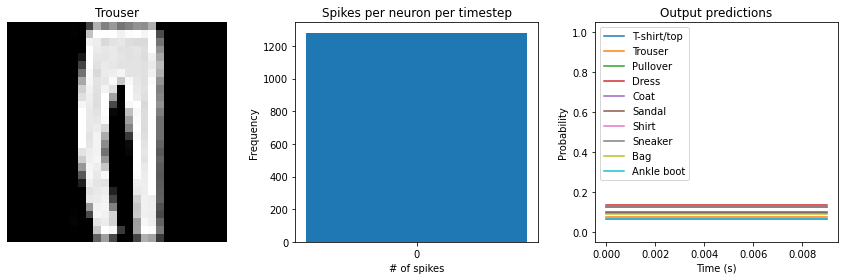

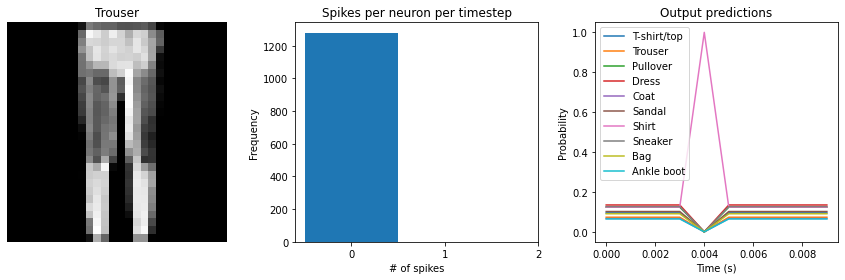

In [9]:
check_output(spiking_model)

Test accuracy: 65.40%
Spike rate per neuron (Hz): min=0.00 mean=0.53 max=20.00


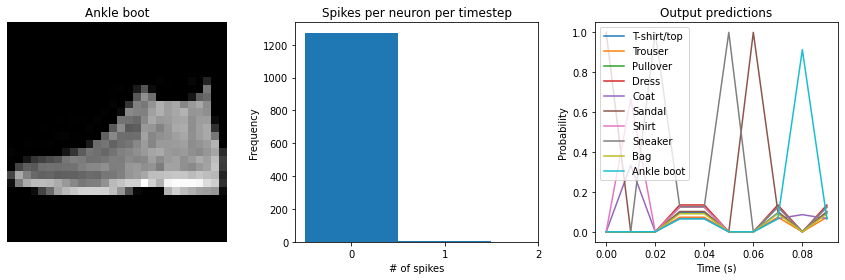

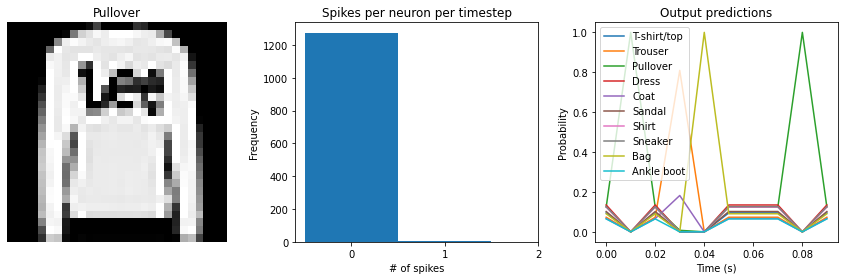

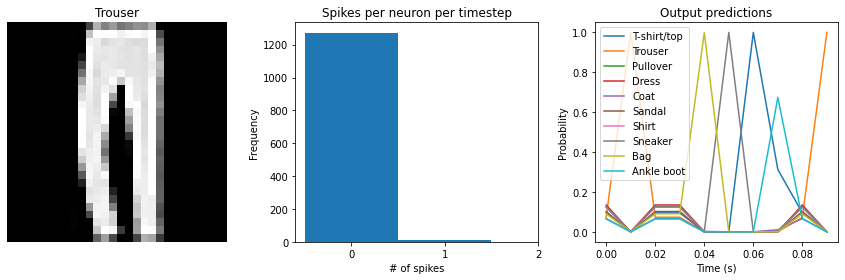

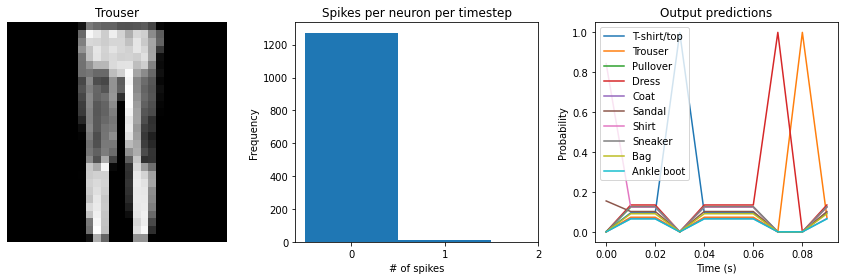

In [13]:
# Note that you don't have to re-train the model to increase the accuracy

# dt=0.01 * 10 timesteps is equivalent to 0.1s of simulated time
check_output(spiking_model, modify_dt=0.01)

Test accuracy: 88.08%
Spike rate per neuron (Hz): min=0.00 mean=0.53 max=17.00


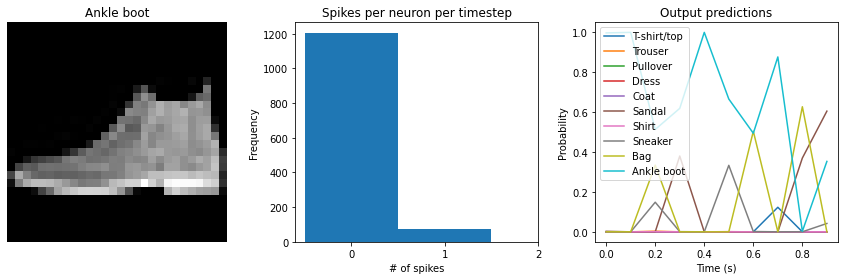

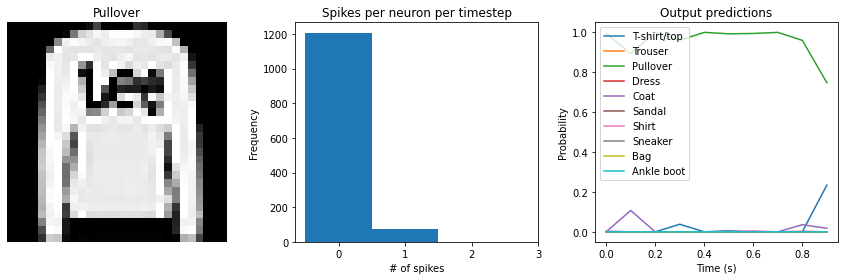

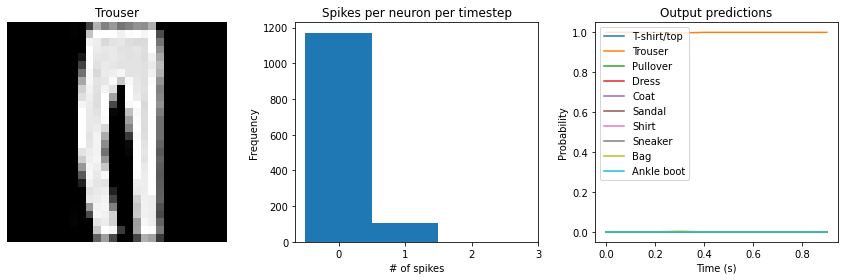

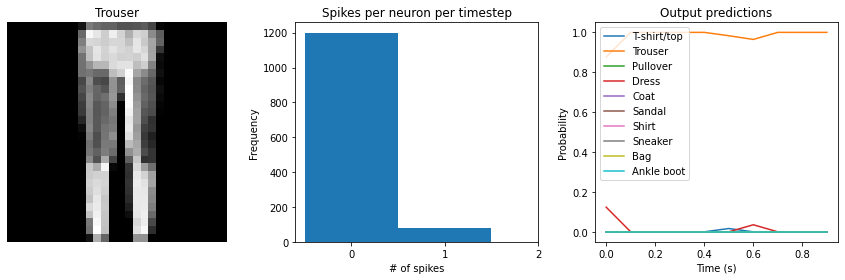

In [11]:
check_output(spiking_model, modify_dt=0.1)

Test accuracy: 88.37%
Spike rate per neuron (Hz): min=0.00 mean=0.53 max=16.90


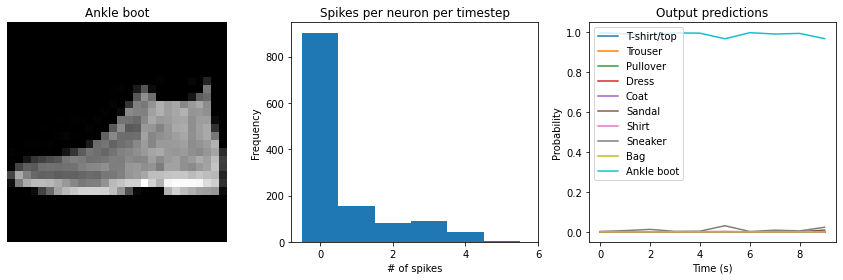

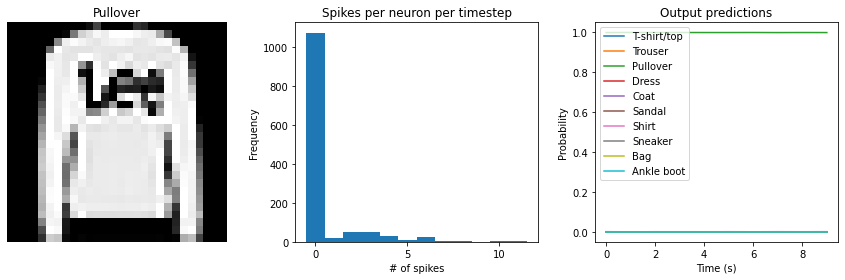

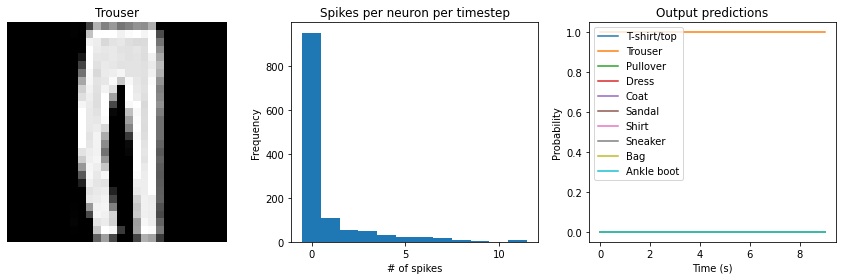

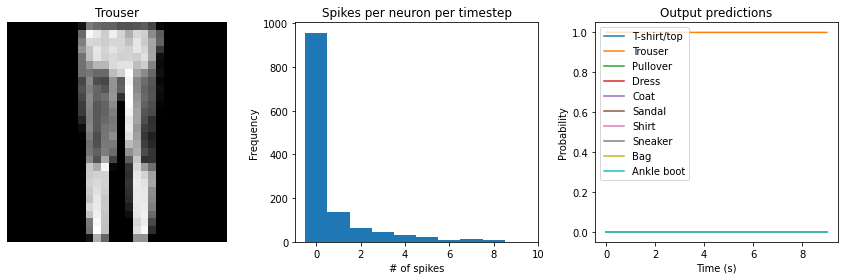

In [12]:
check_output(spiking_model, modify_dt=1)